# Sea Ice Advance and Retreat

Using the daily NSIDC sea ice extent product, figure out the day in each year when sea ice is present in each pixel to calculate day of sea ice advance and retreat, and the duration between thw two

In [1]:
#directory paths
_work_dir='/g/data/jk72/as2285/miz/'
_data_dir='/g/data/jk72/MIZ/'

In [2]:
#useful py libraries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [216]:
import sys
sys.path.append(_work_dir)

from utils.sea_ice_conc import sea_ice_conc

%run {_work_dir}utils/plot_tools.ipynb

In [4]:
%matplotlib inline

In [5]:
#some constants
CLIMAT_DATES=[1981,2010]
EAST_ANT_LONS=[71,160] #longitudes for east Antartica (easterly)
YEAR=2022


# Open the dataset

For this, we are going to treat historical and near real-time data as equivalent.

In [6]:
#lists of both the historical and near real-time files
daily_files = ! ls -d {_data_dir}NSIDC/G02202_V4/seaice_conc_daily*.nc {_data_dir}NSIDC/G10016_V2/daily/*.nc

In [7]:
#open it all
cdr_daily_ds=xr.open_mfdataset(
    daily_files, combine='nested',concat_dim='tdim', data_vars='minimal',
).swap_dims(
    {'tdim':'time', 'x':'xgrid','y':'ygrid'}
).rename(
    {'xgrid':'x','ygrid':'y'}
)  

In [11]:
cdr_daily_ds

<xarray.Dataset>
Dimensions:                      (time: 15919, y: 332, x: 316)
Coordinates:
  * time                         (time) datetime64[ns] 1978-10-25 ... 2022-05-25
  * x                            (x) float32 -3.938e+06 -3.912e+06 ... 3.938e+06
  * y                            (y) float32 4.338e+06 4.312e+06 ... -3.938e+06
Data variables:
    cdr_seaice_conc              (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    nsidc_bt_seaice_conc         (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    nsidc_nt_seaice_conc         (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    projection                   |S1 b''
    qa_of_cdr_seaice_conc        (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    spatial_interpolation_flag   (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    stdev_of_cdr_seaice_conc     (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    temporal_interpolation_flag  (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    latitude                     (y, x) float32 dask.array<chunksize=(332, 316), meta=np.ndarray>
    longitude                    (y, x) float32 dask.array<chunksize=(332, 316), meta=np.ndarray>
Attributes: (12/39)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc
    ...                        ...
    acknowledgment:            This project was supported in part by a grant ...
    platform:                  NIMBUS-7
    sensor:                    SMMR > Scanning Multichannel Microwave Radiometer
    date_created:              2021-06-21T21:22:35Z
    time_coverage_start:       1978-10-25T00:00:00Z
    time_coverage_end:         1978-12-31T23:59:59Z

In [12]:
daily_conc_da=cdr_daily_ds.cdr_seaice_conc

daily_conc_da=daily_conc_da.where(daily_conc_da<=1) #set flagged values to Nan

In [13]:
daily_conc_da

<xarray.DataArray 'cdr_seaice_conc' (time: 15919, y: 332, x: 316)>
dask.array<where, shape=(15919, 332, 316), dtype=float32, chunksize=(366, 332, 316), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1978-10-25 1978-10-26 ... 2022-05-25
  * x        (x) float32 -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
  * y        (y) float32 4.338e+06 4.312e+06 4.288e+06 ... -3.912e+06 -3.938e+06
Attributes:
    long_name:            NOAA/NSIDC Climate Data Record of Passive Microwave...
    standard_name:        sea_ice_area_fraction
    units:                1
    flag_values:          [251 252 253 254 255]
    flag_meanings:        pole_hole lakes coastal land_mask missing_data
    datum:                +ellps=urn:ogc:def:crs:EPSG::4326
    grid_mapping:         projection
    reference:            https://nsidc.org/data/g02202/versions/4/
    ancillary_variables:  stdev_of_cdr_seaice_conc qa_of_cdr_seaice_conc
    valid_range:          [  0 100]
    cell_methods:         tdim: mean

# Define groups starting ending in mid-feb each year

We want to look at each "sea-ice year", which will start/end mid feb (day 46/411 in the year).

In [14]:
# year of the first entry in the dataset
first_year=cdr_daily_ds.time[0].dt.year.values

# if that year doesn't include the sea-ice minimum, increment to the next year
if cdr_daily_ds.time[0].dt.dayofyear>=46:
    first_year+=1

first_year

array(1979)

In [15]:
# year of last entry in the dataset
current_year=cdr_daily_ds.time[-1].dt.year.values

# if that year doesn't include the sea-ice minimum, increment to the previous year
if cdr_daily_ds.time[0].dt.dayofyear<=46:
    current_year-=1

current_year

array(2022)

We are going to use groupby bins, so we need to define bins starting and ending 46th day of each year

In [16]:
years=np.arange(first_year,current_year+2,1)
year_bins=np.array([np.datetime64(str(iYear)+'-02-15') for iYear in years])
year_labels=[iYear for iYear in years[0:-1]]

# Functions to find advance day and retreat day

We need a function to find:
- first time the concentration exceeds 15% for at least 5 days
- last time concentration drops below 15%

the input would be an xarray starting and ending at the sea-ice minimum (15-feb)

To-Do: what happpens if there is sea ice on 15-feb but not on 15-march??

In [17]:
def day_of_advance(conc_da):
    # find times when the concentration for 5 days is >=0.15
    has_ice_da=((conc_da>=0.15).rolling(time=5).mean('time')==1)
    
    # day of advance is the first day when has_ice is true
    advance_day_da=has_ice_da.idxmax(dim='time').where( #idxmax returns first time when true is found
        (has_ice_da.any('time')!=0) #filter out pixels with no-ice
    )
    
    advance_index_da=has_ice_da.argmax(dim='time').where( #argmax returns first index when true is found
        (has_ice_da.any('time')!=0) #filter out pixels with no-ice
    ).rename('index')
    
    return xr.merge([advance_day_da,advance_index_da])

In [18]:
def day_of_retreat(conc_da):
    # find times when the concentration for 5 days is >=0.15, i.e. year has some sea-ice
    has_ice_da=((conc_da>=0.15).rolling(time=5).mean('time')==1)
    
    # criteria for end of sea ice
    no_ice_da=(conc_da>=0.15)
    
    retreat_day_da=no_ice_da.sel(
        time=(no_ice_da.time[::-1]) #index from the end to the start
    ).idxmax(dim='time').where( #idxmax returns first time when true is found
        (has_ice_da.any('time')!=0) #filter out pixels with no-ice
    )
    
    length_of_year=365 #days
    if no_ice_da.time[0].dt.is_leap_year:
        length_of_year=366
    
    retreat_index_da=length_of_year-no_ice_da.sel(
        time=(no_ice_da.time[::-1]) #index from the end to the start
    ).argmax(dim='time').where( #argmax returns first index when true is found
        (has_ice_da.any('time')!=0) #filter out pixels with no-ice
    ).rename('index')
    
    return xr.merge([retreat_day_da, retreat_index_da])
    

# Calculate advance day / retreat day and season

For year of the groups defined (stating/ending Feb 15), find the day when advance and retreat starts:

In [19]:
adv_day_ds=daily_conc_da.groupby_bins('time',year_bins, labels=year_labels).apply(day_of_advance).rename({'time_bins':'year'})

In [20]:
%%time
adv_day_ds.load()

CPU times: user 1min 39s, sys: 41.8 s, total: 2min 21s
Wall time: 1min 22s


<xarray.Dataset>
Dimensions:  (year: 44, x: 316, y: 332)
Coordinates:
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2018 2019 2020 2021 2022
  * x        (x) float32 -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
  * y        (y) float32 4.338e+06 4.312e+06 4.288e+06 ... -3.912e+06 -3.938e+06
Data variables:
    time     (year, y, x) datetime64[ns] NaT NaT NaT NaT NaT ... NaT NaT NaT NaT
    index    (year, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan

In [21]:
adv_day_ds

<xarray.Dataset>
Dimensions:  (year: 44, x: 316, y: 332)
Coordinates:
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2018 2019 2020 2021 2022
  * x        (x) float32 -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
  * y        (y) float32 4.338e+06 4.312e+06 4.288e+06 ... -3.912e+06 -3.938e+06
Data variables:
    time     (year, y, x) datetime64[ns] NaT NaT NaT NaT NaT ... NaT NaT NaT NaT
    index    (year, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan

In [22]:
del adv_day_ds

adv_day_ds=daily_conc_da.groupby_bins('time',year_bins, labels=year_labels).apply(day_of_advance).rename({'time_bins':'year'}).chunk({'x':316, 'y':332, 'year':'auto'})

In [23]:
%%time
adv_day_ds.load()

CPU times: user 1min 39s, sys: 35.5 s, total: 2min 15s
Wall time: 1min 17s


<xarray.Dataset>
Dimensions:  (year: 44, x: 316, y: 332)
Coordinates:
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2018 2019 2020 2021 2022
  * x        (x) float32 -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
  * y        (y) float32 4.338e+06 4.312e+06 4.288e+06 ... -3.912e+06 -3.938e+06
Data variables:
    time     (year, y, x) datetime64[ns] NaT NaT NaT NaT NaT ... NaT NaT NaT NaT
    index    (year, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan

In [30]:
ret_day_ds=daily_conc_da.groupby_bins(
    'time',year_bins[:-1], labels=year_labels[:-1] #drop the last year because it is incomplete
).apply(day_of_retreat).rename({'time_bins':'year'})

In [25]:
adv_day_ds.to_netcdf('/g/data/jk72/as2285/miz/data/adv_day.nc')

In [38]:
ret_day_ds.to_netcdf('/g/data/jk72/as2285/miz/data/ret_day.nc')

Plots for sanity - compare concentrations to dates identified as advance date

No Ice example:

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.09.1/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


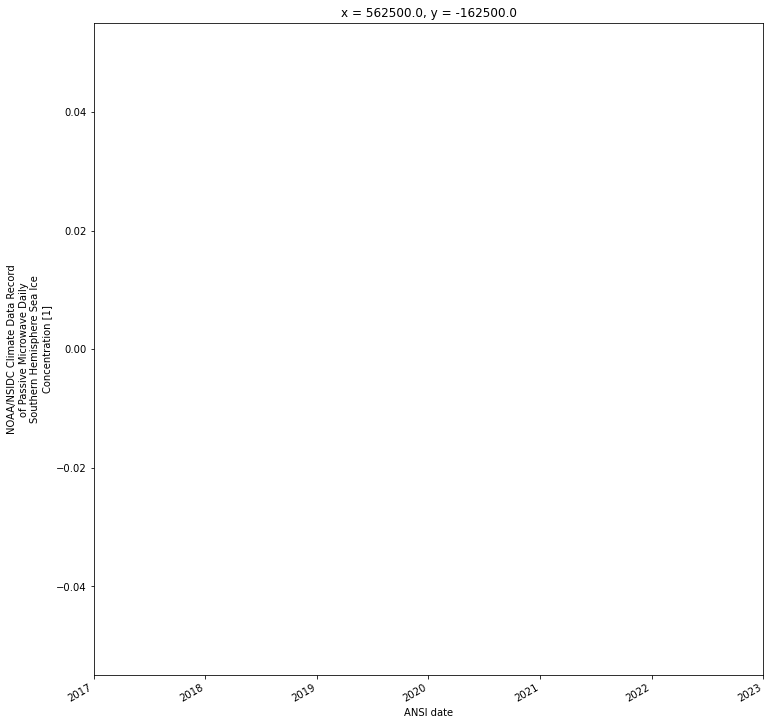

In [27]:
plt.figure(figsize=(12,12))
daily_conc_da.isel(x=180,y=180).plot(xlim=[np.datetime64('2017'),np.datetime64('2023')])

plt.vlines(adv_day_ds.time.isel(x=180,y=180).values,0,1, color='red')

plt.vlines(ret_day_ds.time.isel(x=180,y=180).values,0,1, color='red')


Ice example

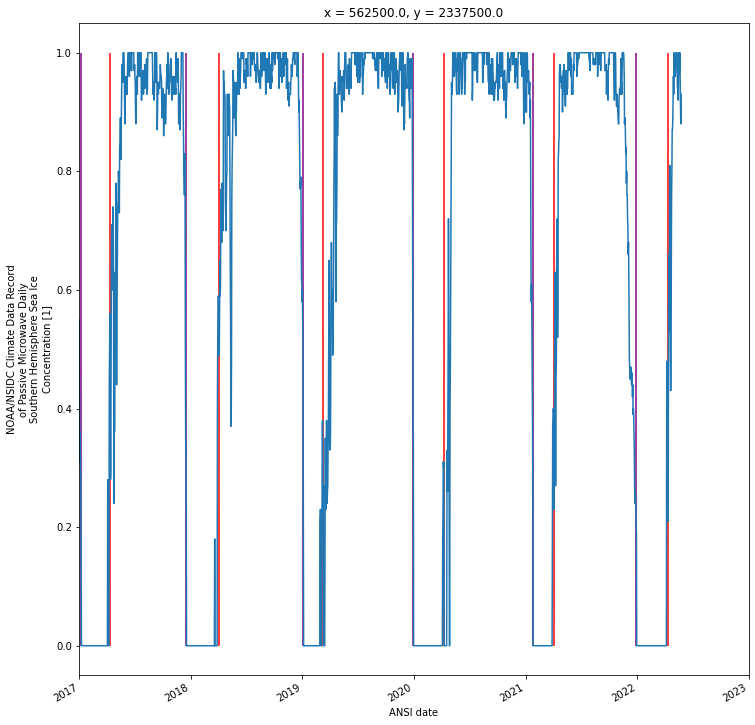

In [39]:
plt.figure(figsize=(12,12))
daily_conc_da.isel(x=180,y=80).plot(xlim=[np.datetime64('2017'),np.datetime64('2023')])

plt.vlines(adv_day_ds.time.isel(x=180,y=80).values,0,1, color='red')

plt.vlines(ret_day_ds.time.isel(x=180,y=80).values,0,1, color='purple')


# Plots of sea ice advance / retreat / duration for a year

In [6]:
YEAR=1982

In [10]:
adv_day_ds=xr.load_dataset(f'{_work_dir}data/adv_day.nc')

In [11]:
adv_day_ds

<xarray.Dataset>
Dimensions:  (year: 44, x: 316, y: 332)
Coordinates:
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2018 2019 2020 2021 2022
  * x        (x) float32 -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
  * y        (y) float32 4.338e+06 4.312e+06 4.288e+06 ... -3.912e+06 -3.938e+06
Data variables:
    time     (year, y, x) datetime64[ns] NaT NaT NaT NaT NaT ... NaT NaT NaT NaT
    index    (year, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan

In [12]:
ret_day_ds=xr.load_dataset(f'{_work_dir}data/ret_day.nc')

The functions here are written to provide the advance and retreat days in two ways.
1. a np.datetime object
2. the number of days since sea ice minima (Feb-16)

Check they look the same:

Text(0.5, 1.0, 'Index + 46 days - Sea Ice Advance 1982')

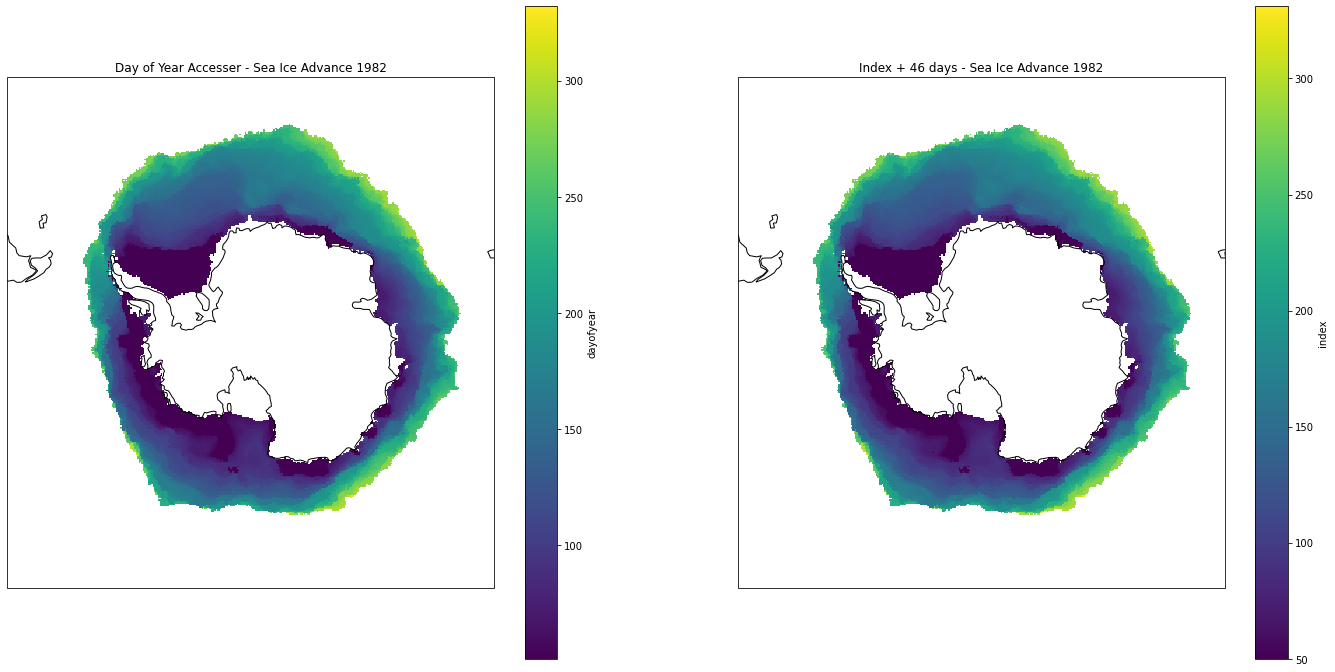

In [13]:
plt.figure(figsize=(24,12))
ax=plt.subplot(1,2,1,projection=ccrs.SouthPolarStereo())

adv_day_ds.time.sel(year=YEAR).dt.dayofyear.plot.pcolormesh(
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70)
)

ax.coastlines()
plt.title('Day of Year Accesser - Sea Ice Advance ' + str(YEAR) )

ax=plt.subplot(1,2,2,projection=ccrs.SouthPolarStereo())

(adv_day_ds.sel(year=YEAR).index+46).plot.pcolormesh(
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70)
)

ax.coastlines()
plt.title('Index + 46 days - Sea Ice Advance ' + str(YEAR))

#check the two plots are the same :)

Text(0.5, 1.0, 'Index + 46 Days - Sea Ice Retreat 1982')

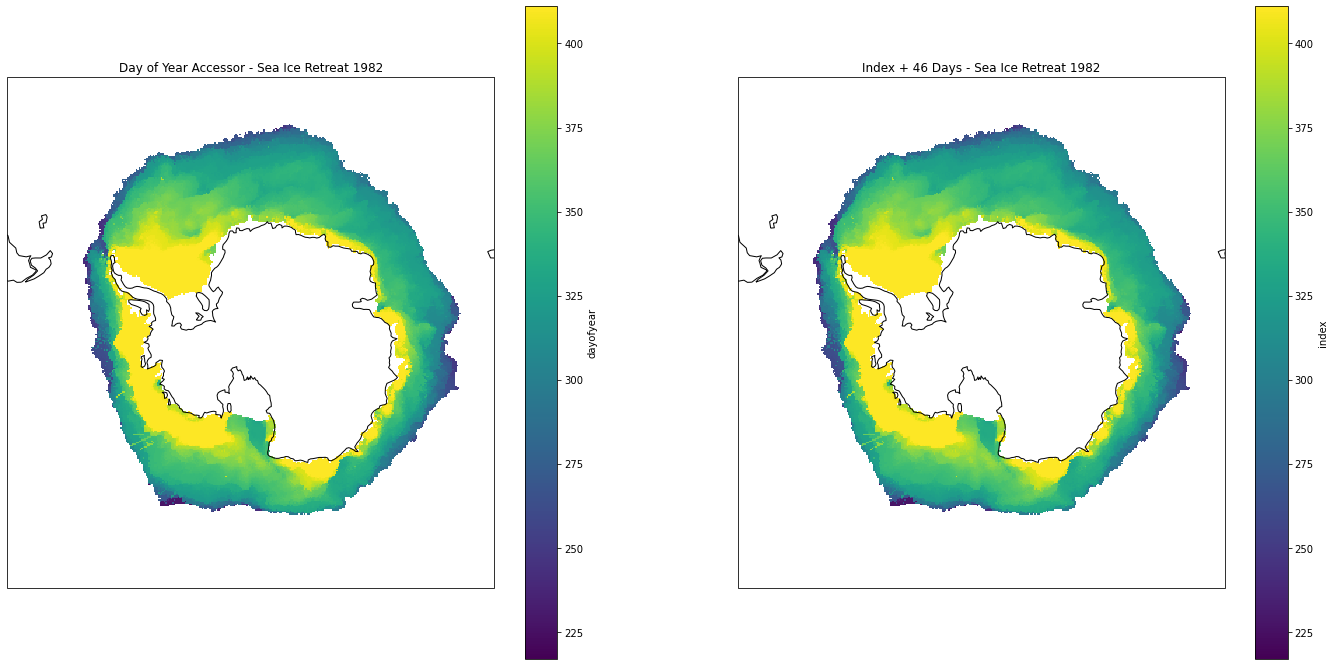

In [14]:
plt.figure(figsize=(24,12))
ax=plt.subplot(1,2,1,projection=ccrs.SouthPolarStereo())

#Corrections for over the year break
ret_dayofyear_da=ret_day_ds.time.dt.dayofyear
ret_dayofyear_da=ret_dayofyear_da.where(ret_dayofyear_da>46,other=(ret_dayofyear_da+365))


ret_dayofyear_da.sel(year=YEAR).plot.pcolormesh(
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70)
)

ax.coastlines()
plt.title('Day of Year Accessor - Sea Ice Retreat ' + str(YEAR))


ax=plt.subplot(1,2,2,projection=ccrs.SouthPolarStereo())

(ret_day_ds.sel(year=YEAR).index+46).plot.pcolormesh(
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70)
)

ax.coastlines()
plt.title('Index + 46 Days - Sea Ice Retreat ' + str(YEAR))

Just a random example to show the durations calculated look sensible

In [15]:
duration_da=ret_day_ds.index-adv_day_ds.index

Text(0.5, 1.0, 'Sea Ice Duration')

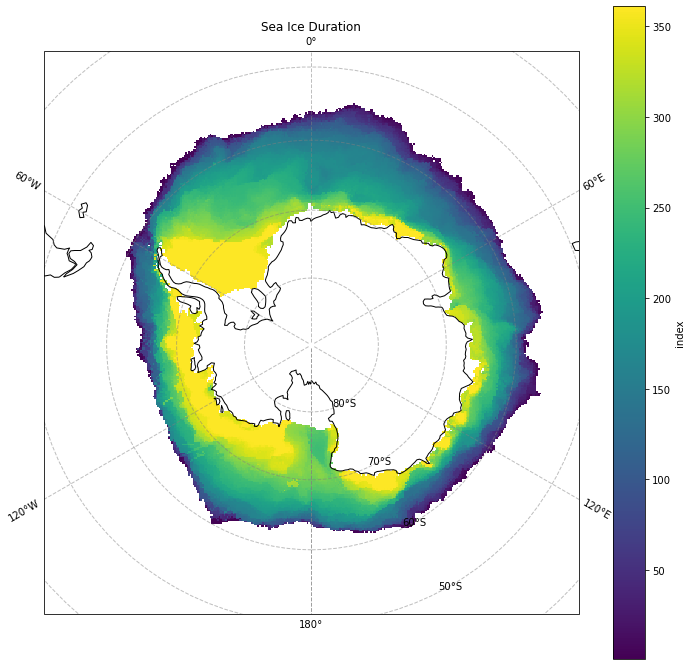

In [16]:
plt.figure(figsize=(12,12))
ax=plt.subplot(projection=ccrs.SouthPolarStereo(true_scale_latitude=-70))



duration_da.sel(year=YEAR).plot.pcolormesh(transform=ccrs.SouthPolarStereo(true_scale_latitude=-70))

ax.coastlines()

gl = ax.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',
    #xlocs=[80,120,160], ylocs=[-60,-90]
)

plt.title('Sea Ice Duration')

# Climatologies

In [45]:
def mean_st_dev(da, dates=CLIMAT_DATES):
    result_ds=xr.Dataset()
    result_ds['ave']=da.sel(year=slice(CLIMAT_DATES[0],CLIMAT_DATES[1])).mean('year')
    result_ds['st_dev']=da.sel(year=slice(CLIMAT_DATES[0],CLIMAT_DATES[1])).std('year')
    return result_ds

In [65]:
adv_climat_ds=mean_st_dev(adv_day_ds.index)
ret_climat_ds=mean_st_dev(ret_day_ds.index)
dur_climat_ds=mean_st_dev(duration_da)

Text(0.5, 1.0, 'Sea Ice Advance Mean')

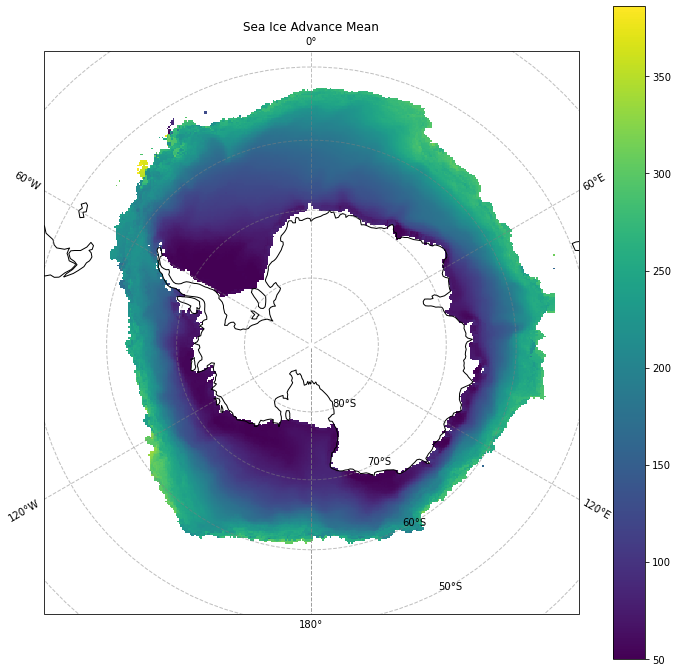

In [66]:
plt.figure(figsize=(12,12))
ax=plt.subplot(projection=ccrs.SouthPolarStereo())

plt.pcolormesh(
    adv_climat_ds.x,
    adv_climat_ds.y,
    adv_climat_ds.ave+46,
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
)

gl = ax.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',
    #xlocs=[80,120,160], ylocs=[-60,-90]
)

ax.coastlines()
plt.colorbar()
plt.title('Sea Ice Advance Mean')

Text(0.5, 1.0, 'Sea Ice Retreat')

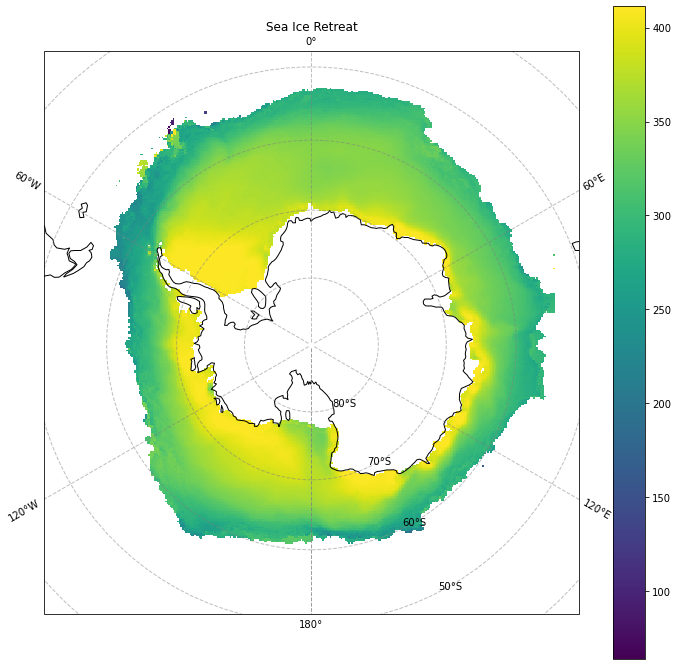

In [67]:
plt.figure(figsize=(12,12))
ax=plt.subplot(projection=ccrs.SouthPolarStereo())

plt.pcolormesh(
    ret_climat_ds.x,
    ret_climat_ds.y,
    ret_climat_ds.ave+46,
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
)

gl = ax.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',
    #xlocs=[80,120,160], ylocs=[-60,-90]
)

ax.coastlines()
plt.colorbar()
plt.title('Sea Ice Retreat')

Text(0.5, 1.0, 'Sea Ice Duration')

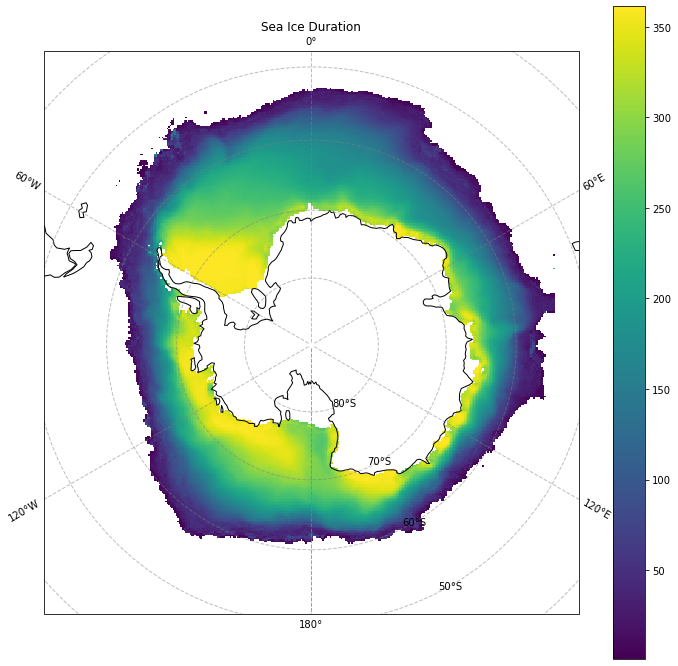

In [58]:
plt.figure(figsize=(12,12))
ax=plt.subplot(projection=ccrs.SouthPolarStereo())

plt.pcolormesh(
    dur_climat_ds.x,
    dur_climat_ds.y,
    dur_climat_ds.ave,
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
)

gl = ax.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',
    #xlocs=[80,120,160], ylocs=[-60,-90]
)

ax.coastlines()
plt.colorbar()
plt.title('Sea Ice Duration')

# Anomalies

In [59]:
YEAR=2021

Text(0.5, 1.0, 'Sea Ice Advance - 2021')

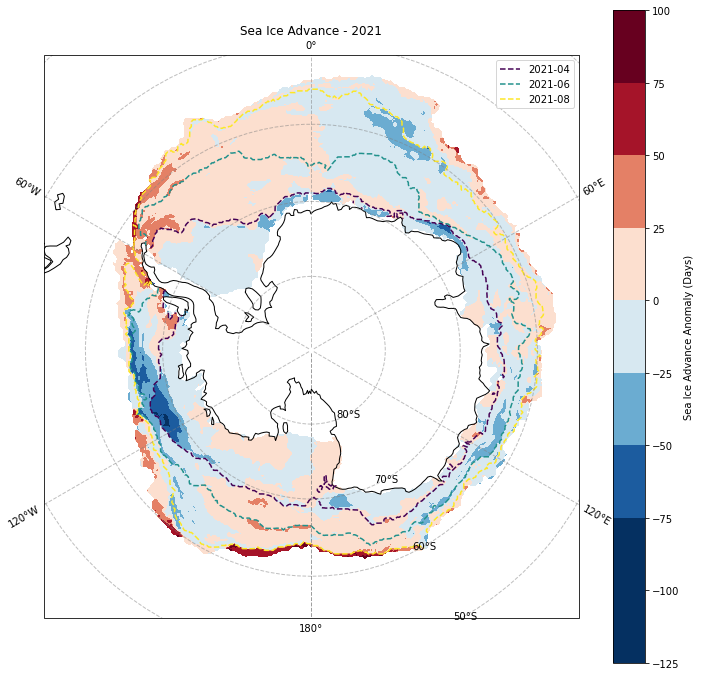

In [230]:
to_plot_da=(adv_day_ds.index-adv_climat_ds.ave).where(adv_day_ds.index.isnull!=np.nan).sel(year=YEAR)

plt.figure(figsize=(12,12))
ax=plt.subplot(projection=ccrs.SouthPolarStereo())

plt.contourf(
    to_plot_da.x,
    to_plot_da.y,
    to_plot_da,
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
    cmap='RdBu_r',
    vmin=-75,vmax=75
)
plt.colorbar(label='Sea Ice Advance Anomaly (Days)')

contour_date_ls=[
    np.datetime64(f'{YEAR}-{iMonth:02.0f}-01') for iMonth in [4,6,8] #july, august, sept, nov
]

cs=plt.contour(
    adv_day_ds.x,
    adv_day_ds.y,
    adv_day_ds.index.sel(year=YEAR),
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
    levels=[(iCon-np.datetime64(f'{YEAR}-02-16')).astype(int) for iCon in contour_date_ls],
    linestyles='dashed'
)

for i in np.arange(0,len(contour_date_ls)):
    cs.collections[i].set_label(s=np.datetime_as_string(contour_date_ls[i], 'M')) 

gl = ax.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',
  #  xlocs=[80,120,160], ylocs=[-60,-80]
)

plt.legend()
ax.coastlines()
plt.title('Sea Ice Advance - '+str(YEAR))


Text(0.5, 1.0, 'Sea Ice Retreat - 2021')

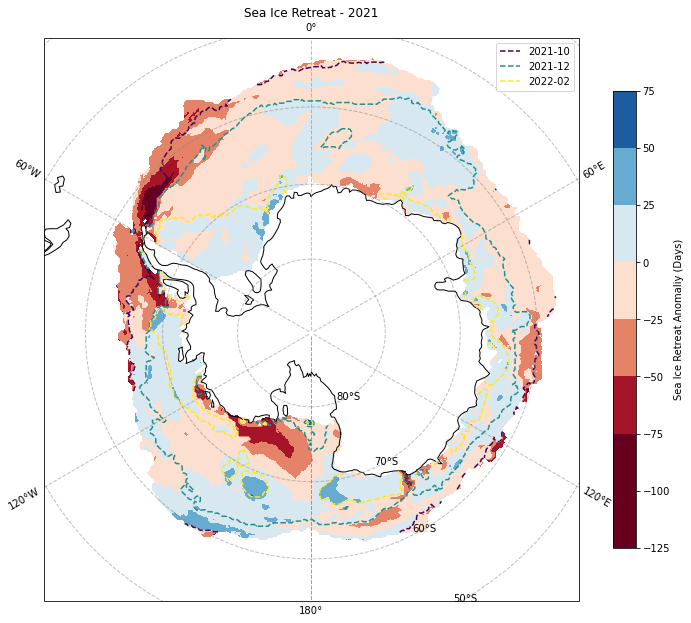

In [228]:
to_plot_da=(ret_day_ds.index-ret_climat_ds.ave).where(ret_day_ds.index.isnull!=np.nan).sel(year=YEAR)

plt.figure(figsize=(12,12))
ax=plt.subplot(projection=ccrs.SouthPolarStereo())

plt.contourf(
    to_plot_da.x,
    to_plot_da.y,
    to_plot_da,
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
    cmap='RdBu',
    vmin=-75,vmax=75
)

plt.colorbar(shrink=0.7, label='Sea Ice Retreat Anomaliy (Days)')


contour_date_ls=[
    *[np.datetime64(f'{YEAR}-{iMonth:02.0f}-01') for iMonth in [10,12]],
    np.datetime64(f'{YEAR+1}-02-01')
]

cs=plt.contour(
    ret_day_ds.x,
    ret_day_ds.y,
    ret_day_ds.index.sel(year=YEAR),
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
    levels=[(iCon-np.datetime64(f'{YEAR}-02-16')).astype(int) for iCon in contour_date_ls],
    linestyles='dashed'
)

for i in np.arange(0,len(contour_date_ls)):
    cs.collections[i].set_label(s=np.datetime_as_string(contour_date_ls[i], 'M')) 

gl = ax.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',
  #  xlocs=[80,120,160], ylocs=[-60,-80]
)

plt.legend()

ax.coastlines()
plt.title('Sea Ice Retreat - '+str(YEAR))

In [223]:
YEAR=2021

Text(0.5, 1.0, 'Sea Ice Duration - 2021')

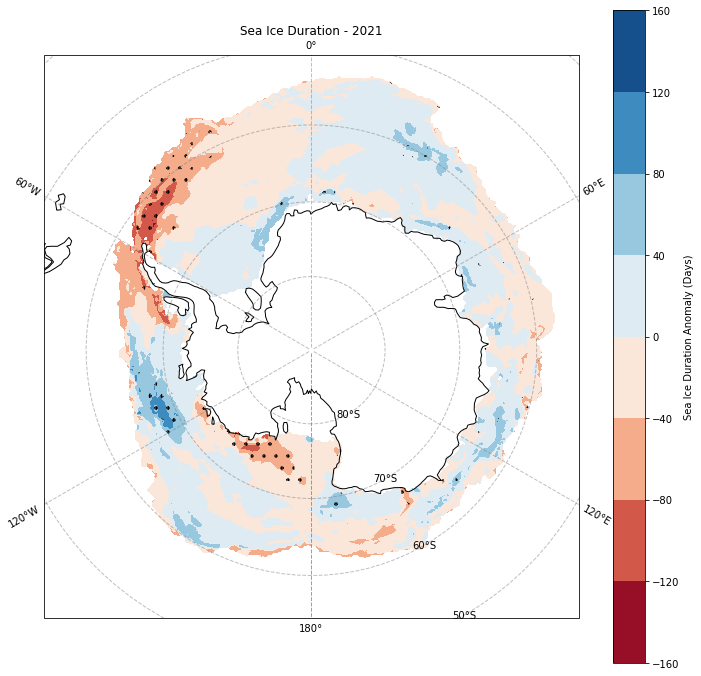

In [229]:
to_plot_da=(duration_da-dur_climat_ds.ave).where(duration_da.isnull!=np.nan).sel(year=YEAR)

plt.figure(figsize=(12,12))
ax=plt.subplot(projection=ccrs.SouthPolarStereo())

plt.contourf(
    to_plot_da.x,
    to_plot_da.y,
    to_plot_da,
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
    cmap='RdBu'
)

plt.colorbar(label='Sea Ice Duration Anomaly (Days)')

plot_stipling(
    to_plot_da,
    2*dur_climat_ds.st_dev,
    ax)

gl = ax.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',
  #  xlocs=[80,120,160], ylocs=[-60,-80]
)

ax.coastlines()
plt.title('Sea Ice Duration - '+str(YEAR))

- Validation
